In [12]:
from typing import Annotated, List

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage



class State(TypedDict):

    #messages: Annotated[list, add_messages]
    """
    Estado del grafo: historial de mensajes.
    """
    finished: bool
    messages: Annotated[List[BaseMessage], add_messages]


In [13]:
from datetime import datetime, time
from sqlalchemy.orm import Session
from src.app.models.restaurant import MenuItem, Reservation
from src.app.databse.database import get_db
from langchain_core.tools import tool

@tool
def get_menu_items() -> str:
    """Obtiene los ítems del menú desde la base de datos."""

    with next(get_db()) as db:  
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío."
        menu = "\n".join([f"{item.name} - {item.price}€" for item in items])
    return f"Este es el menú actual:\n{menu}"

@tool
def get_menu() -> str:
    """Devuelve el menú actual del restaurante."""
    with next(get_db()) as db:
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío en este momento."
        return "\n".join([f"{item.name} - {item.price}€" for item in items])



In [14]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langgraph.graph import StateGraph, START, END
from langchain.schema import HumanMessage, AIMessage
from langchain_core import tools
from src.app.utils.prompts import SYSTEM_PROMPT, WELCOME_MESSAGE
from langgraph.prebuilt import ToolNode


# Configurar el modelo de OpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.5)
llm_with_tools = llm.bind_tools([get_menu])



def human_node(state: State) -> State:
    """
    Nodo humano que espera input y decide si finalizar la conversación.
    """
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # Si el usuario dice "adiós", finaliza
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    # Añade el input al estado
    return state | {"messages": [HumanMessage(content=user_input)]}

def chatbot_node(state: State) -> State:
    """
    Nodo principal del chatbot: invoca el LLM y detecta tool_calls.
    """
    messages = state["messages"]

    # Agregar el prompt del sistema
    system_message = AIMessage(content=SYSTEM_PROMPT)

    # Invocar el modelo con herramientas asociadas
    response = llm_with_tools.invoke([system_message] + messages)

    # Actualizar el historial de mensajes con la respuesta
    return {"messages": messages + [response]}

# Nodo de herramientas: ejecuta herramientas solicitadas
tool_node = ToolNode([get_menu])


In [15]:
from langgraph.graph import StateGraph, START, END
def maybe_route_to_tools(state: State) -> str:
    """
    Decide si ir al tool_node o finalizar el flujo.
    """
    last_message = state["messages"][-1]

    # Si hay tool_calls, dirigir al nodo tools
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return "__end__"  # Evita rutas no deseadas hacia "human"

def maybe_exit_human_node(state: State) -> str:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

builder = StateGraph(State)

builder.add_node("chatbot", chatbot_node)
builder.add_node("human", human_node)
#builder.add_node("tools", tool_node)

#builder.add_conditional_edges("chatbot", maybe_route_to_tools)
builder.add_edge(START, "chatbot")    # flujo inicial

#builder.add_edge("tools", "chatbot")  # tools regresa solo a chatbot
builder.add_edge("chatbot", "human")  # human regresa a chatbot
builder.add_conditional_edges("human", maybe_exit_human_node)


grafo = builder.compile()


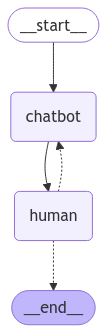

In [16]:
from IPython.display import Image, display
 
Image(grafo.get_graph().draw_mermaid_png())

In [17]:
def maybe_route_to_tools(state: State) -> str:
    """
    Decide si ir al tool_node o finalizar el flujo.
    """
    last_message = state["messages"][-1]

    # Si hay tool_calls, dirigir al nodo tools
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return "__end__"  # Evita rutas no deseadas hacia "human"

def maybe_exit_human_node(state: State) -> str:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

builder = StateGraph(State)

builder.add_node("chatbot", chatbot_node)
#builder.add_node("human", human_node)
builder.add_node("tools", tool_node)

builder.add_conditional_edges("chatbot", maybe_route_to_tools)
builder.add_edge(START, "chatbot")    # flujo inicial

builder.add_edge("tools", "chatbot")  # tools regresa solo a chatbot
#builder.add_edge("chatbot", "human")  # human regresa a chatbot
#builder.add_conditional_edges("human", maybe_exit_human_node)


grafo = builder.compile()

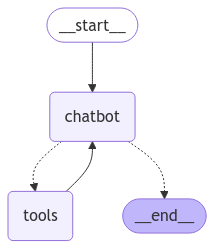

In [18]:
from IPython.display import Image, display
 
Image(grafo.get_graph().draw_mermaid_png())

In [ ]:

from langgraph.graph import StateGraph, START, END
def maybe_route_to_tools(state: State) -> str:
    """
    Decide si ir al nodo de herramientas o al nodo humano.
    """
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return "human"

def maybe_exit_human_node(state: State) -> str:
    """
    Decide si finalizar el flujo o ir a tools.
    """
    if state.get("finished", False):
        return END  # Finaliza el grafo
    else:
        return "chatbot"

# Construcción del grafo
builder = StateGraph(State)
subgraph = StateGraph(State)

# Definición de nodos
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", tool_node)
builder.add_node("human", human_node)

builder.add_edge(START, "chatbot")  # Inicio → chatbot
builder.add_conditional_edges("chatbot", maybe_route_to_tools)  # chatbot → tools/human
builder.add_conditional_edges("human", maybe_exit_human_node)  # human → END/tools
builder.add_edge("tools", "chatbot")  # tools → chatbot

builder.add_edge(START, "chatbot")  # Inicio → chatbot


# Definición de conexiones
#builder.add_edge("tools", "chatbot")  # tools → chatbot


# Compilar el grafo
grafo = builder.compile()



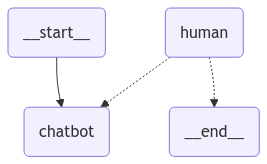

In [98]:
from IPython.display import Image, display
 
Image(grafo.get_graph().draw_mermaid_png())

TypeError: BaseTool.__call__() missing 1 required positional argument: 'tool_input'

In [10]:
from src.app.databse.database import get_db
from langchain_core.tools import tool
from datetime import datetime, time
from sqlalchemy.orm import Session
from src.app.models.restaurant import MenuItem, Reservation
from src.app.databse.database import get_db
from langchain_core.tools import tool


def get_menu() -> str:
    """Devuelve el menú actual del restaurante."""
    with next(get_db()) as db:
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío en este momento."
        return "\n".join([f"{item.name} - {item.price}€ - {item.category}" for item in items])
    
def get_menu_with_ingredients() ->str:
    """Devuelve el menú con los ingredientes de cada plato."""
    with next(get_db()) as db:
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío en este momento."
        menu = "\n".join([f"{item.name} - {item.price}€ - {item.category} - {item.ingredients} ,Allergens: {item.allergens}" for item in items])
    return f"Este es el menú actual con los ingredientes:\n{menu}"

def get_menu_item(dish: str) -> str:
    """Devuelve un plato específico del menú."""
    with next(get_db()) as db:
        item = db.query(MenuItem).filter(MenuItem.name == dish).first()
        if not item:
            return "No se encontró el plato especificado."
        return f"{item.name} - {item.price}€ - {item.category}"
    
get_menu_with_ingredients()
get_menu_item("Caprese")

'Caprese - 8.0€ - MenuCategory.ANTIPASTI'